In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
POWERS = ['0', '4', '3', '2', '1']
# POWERS = ['0', '2']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n37/"

def get_chance(power):
    if power == '0':
        return '100'
    elif power == '4':
        return '93.75'
    elif power == '3':
        return '87.5'
    elif power == '2':
        return '75'
    elif power == '1':
        return '50'
    
def get_power_index(power):
    if power == '0':
        return 0
    elif power == '4':
        return 1
    elif power == '3':
        return 2
    elif power == '2':
        return 3
    elif power == '1':
        return 4
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in POWERS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in POWERS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in POWERS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in POWERS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in POWERS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in POWERS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in POWERS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in POWERS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in POWERS]
PLOT_X = [get_chance(p) + '%' for p in POWERS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in POWERS:
        runSketchTweets("SketchingTweet-v2-n37", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(POWERS)
    termfreq = [0] * len(POWERS)
    query_result = [0] * len(POWERS)
    query_similarity = [0] * len(POWERS)
    query_lookups = [0] * len(POWERS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(POWERS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(POWERS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            power = filename.group(4)

            if name == "summary":    
                for p in POWERS:
                    if power == p:
                        summary[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in POWERS:
                    if power == p:
                        termfreq[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in POWERS:
                    if power == p:
                        query_result[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in POWERS:
                    if power == p:
                        query_similarity[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in POWERS:
                    if power == p:
                        query_lookups[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                  

    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

,Summary_100%,Summary_93.75%,Summary_87.5%,Summary_75%,Summary_50%
Run,1,1,1,1,1
Chance,100.0%,93.75%,87.5%,75.0%,50.0%
Index time unit,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,22852,22852,22852,22852,22852
Indexed tweet counts,206118,206118,206118,206118,206118
Index size,226241,212588,198634,170786,114679


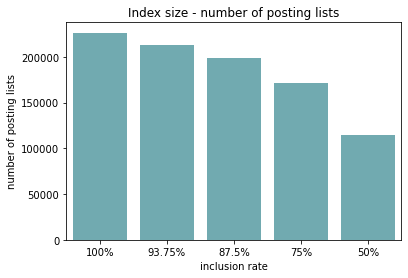

Summary_100%      226241
Summary_93.75%    212588
Summary_87.5%     198634
Summary_75%       170786
Summary_50%       114679
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

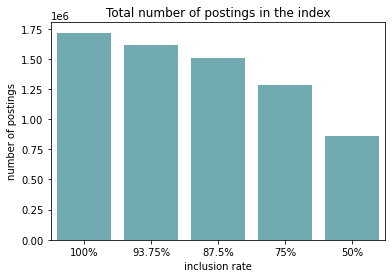

Total number of postings:


[1716961, 1617589, 1507728, 1286890, 860292]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

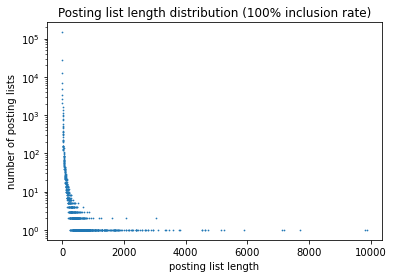

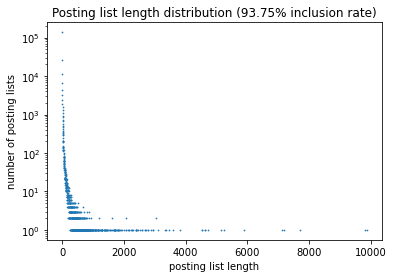

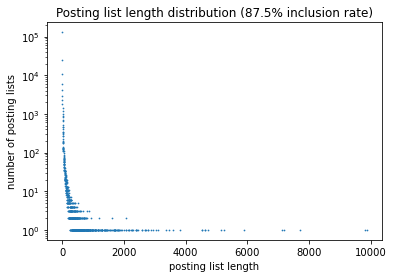

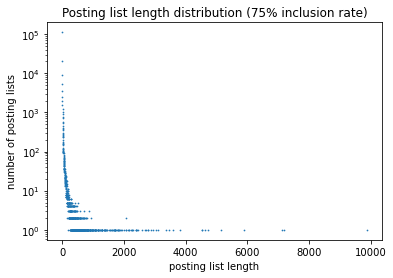

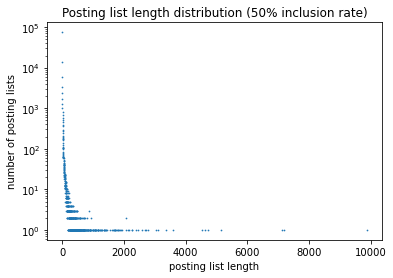

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.589079786599246, 7.609032494778633, 7.590482998882367, 7.535102408862553, 7.501739638469118]


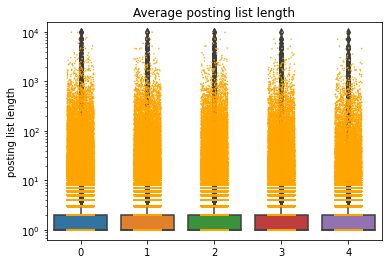

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.57143,0.58333,0.58333,0.60000,0.50000,7350,3612,3612,2960,666
1,152573,152573,152573,103379,103379,0.50000,0.50000,0.50000,0.66667,0.66667,6966,6966,6966,2511,2511
2,-1,-1,-1,-1,152451,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,464
3,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,205139,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22847,-1,-1,-1,196136,205121,0.00000,0.00000,0.00000,0.50000,1.00000,-1,-1,-1,164,1
22848,-1,-1,-1,-1,100625,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,1552
22849,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1
22850,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1


In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.57143,0.58333,0.58333,0.60000,0.50000,7350,3612,3612,2960,666
1,152573,152573,152573,103379,103379,0.50000,0.50000,0.50000,0.66667,0.66667,6966,6966,6966,2511,2511
8,46552,205551,205551,205551,205551,0.60000,0.50000,0.66667,0.66667,0.66667,46145,112,75,75,75
11,205082,205082,205082,205082,205111,0.50000,0.50000,0.50000,0.60000,0.50000,114,114,114,95,64
13,177541,177541,177541,177541,206008,0.60000,0.60000,0.60000,0.60000,0.66667,8080,8080,8080,8080,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22841,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,7,5,4
22842,98046,98046,98046,98046,98046,0.53846,0.53846,0.58333,0.50000,0.55556,96330,96330,87780,72950,47943
22844,206109,206109,206109,206109,206109,0.60000,0.60000,0.60000,0.75000,1.00000,5,5,5,4,2
22846,186451,186451,186451,186451,-1,0.62500,0.62500,0.62500,0.50000,0.00000,144,144,144,96,-1


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[8143, 7204, 6273, 4693, 2755]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 93.75% of terms, we can find 88.47% truly similar tweets
Using 87.5% of terms, we can find 77.04% truly similar tweets
Using 75% of terms, we can find 57.63% truly similar tweets
Using 50% of terms, we can find 33.83% truly similar tweets


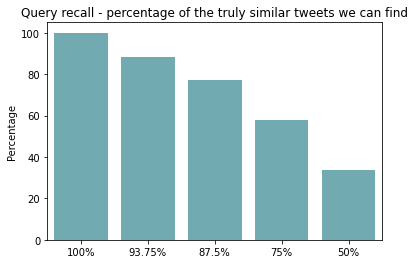

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
predict_similar = query_result_similarity_lookup[is_predict_similar]
num_predict_similar = predict_similar.shape[0]
predict_similar

num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[8143, 8781, 9475, 10976, 14806]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 93.75% of terms, 82.04% tweets that we found similar are truly similar tweets
Using 87.5% of terms, 66.21% tweets that we found similar are truly similar tweets
Using 75% of terms, 42.76% tweets that we found similar are truly similar tweets
Using 50% of terms, 18.61% tweets that we found similar are truly similar tweets


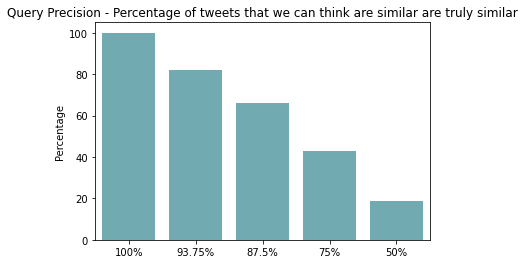

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.57143,0.58333,0.58333,0.60000,0.50000,7350,3612,3612,2960,666
19,204516,204516,205909,205909,204516,0.66667,0.60000,0.50000,0.66667,1.00000,342,220,4,3,1
44,146902,146902,146902,146902,146902,0.50000,0.50000,0.50000,0.50000,0.50000,16284,16284,16284,16284,16284
48,205111,205111,205111,205111,205111,0.62500,0.62500,0.66667,0.80000,1.00000,176,176,90,75,45
78,35710,35710,35710,35710,35710,1.00000,1.00000,1.00000,1.00000,1.00000,32526,32526,19348,19348,12900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22837,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,7,5,4
22841,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,7,5,4
22842,98046,98046,98046,98046,98046,0.53846,0.53846,0.58333,0.50000,0.55556,96330,96330,87780,72950,47943
22844,206109,206109,206109,206109,206109,0.60000,0.60000,0.60000,0.75000,1.00000,5,5,5,4,2


In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 1754, 2788, 3623, 2637]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 93.75% of terms, 24.35% queries need less lookups before correctly finding the true similar tweets
Using 87.5% of terms, 44.44% queries need less lookups before correctly finding the true similar tweets
Using 75% of terms, 77.2% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 95.72% queries need less lookups before correctly finding the true similar tweets


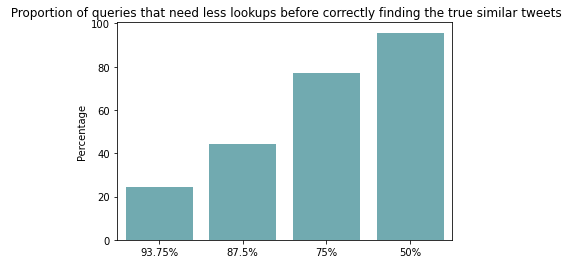

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

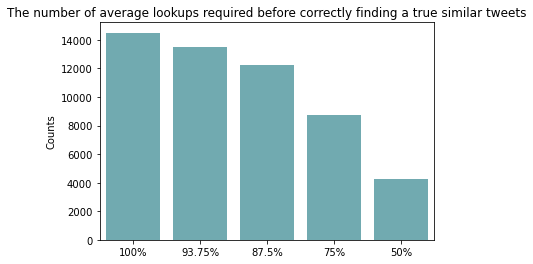

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 93.75% of terms, 6.93% of less lookups are needed for correctly finding a true similar tweets
By using 87.5% of terms, 15.61% of less lookups are needed for correctly finding a true similar tweets
By using 75% of terms, 39.94% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 70.54% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_93.75%,Index_time_run2_93.75%,Index_time_run3_93.75%,Index_time_run1_87.5%,Index_time_run2_87.5%,Index_time_run3_87.5%,Index_time_run1_75%,Index_time_run2_75%,Index_time_run3_75%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,11.2129,10.3236,9.3451,13.3009,14.3380,11.8725,13.3006,13.0489,12.9763,12.7842,13.8040,12.0783,15.1788,13.0417,12.0703
1,5.7177,5.5976,4.6829,6.7832,6.6316,6.6574,5.6799,6.2488,5.6864,5.3779,6.2436,5.5797,5.5337,5.9953,5.0911
2,5.3090,5.1402,4.8248,6.0016,6.9084,7.1842,5.2161,5.9533,5.0466,4.8842,5.8440,5.7236,5.4158,6.2583,4.6346
3,5.8280,4.8864,4.5603,5.1147,5.9429,5.8311,4.9726,4.6885,4.3665,4.6820,4.9633,4.7905,5.2017,4.5257,4.5600
4,7.1097,4.4801,5.1490,4.4341,5.5374,6.1258,4.6345,4.4553,4.6463,5.0409,4.9833,4.7253,5.6562,4.5943,3.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2.1877,2.0860,2.1541,3.1967,3.2804,2.4457,2.4397,2.2454,2.3190,2.7744,2.8460,2.7805,1.9187,2.0952,2.3223
202,2.4261,19.9100,2.0436,3.0000,3.3081,2.4680,2.4638,2.1915,2.3134,2.5752,2.7731,2.5535,2.1668,2.4659,2.0776
203,1.9928,2.8884,1.9293,18.2074,3.0256,2.2684,2.2636,2.3999,2.2753,2.4731,2.9646,2.4870,2.2008,1.9478,1.9076
204,2.3220,2.1764,1.9503,3.2596,3.1129,2.2938,2.3302,2.3784,2.3377,2.4934,2.8642,2.4987,1.9934,1.9626,1.9681


By using 100% of terms, the average time for indexing 1000 tweets is 3.163 milliseconds
By using 93.75% of terms, the average time for indexing 1000 tweets is 3.6244 milliseconds
By using 87.5% of terms, the average time for indexing 1000 tweets is 3.5414 milliseconds
By using 75% of terms, the average time for indexing 1000 tweets is 3.2011 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 2.8671 milliseconds


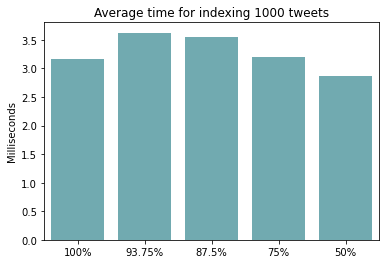

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_93.75%,Query_time_run2_93.75%,Query_time_run3_93.75%,Query_time_run1_87.5%,Query_time_run2_87.5%,Query_time_run3_87.5%,Query_time_run1_75%,Query_time_run2_75%,Query_time_run3_75%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.6319,2.3472,3.0720,1.8604,2.2105,2.2603,1.9957,2.2982,2.0683,2.6450,3.1490,1.8260,1.6443,1.5628,1.4662
1,306.5220,342.2582,325.3931,292.4258,322.8436,299.7372,295.7300,317.0667,333.1356,298.8284,264.7653,272.1491,176.4614,213.3886,160.3322
2,201.9666,207.7357,203.1871,179.6310,177.4181,187.1444,180.6644,183.5220,171.6325,122.5380,121.4692,120.6791,47.6793,63.2502,48.3277
3,214.2091,202.6832,212.9802,183.2642,184.0899,185.4069,198.0641,179.7219,183.2615,129.4968,116.0243,125.6947,52.5176,64.9281,58.7168
4,211.2461,213.4300,218.9743,195.7802,197.4699,201.1483,202.3604,211.5710,178.0558,139.7640,123.9717,134.5331,50.2068,58.1568,54.6975
5,202.2331,199.1583,212.6085,186.1898,188.3992,197.8055,193.3894,187.9252,172.2204,127.5122,111.7531,129.8145,49.5788,55.5216,55.8045
6,210.3241,207.3678,217.4999,195.1606,188.7259,207.6251,208.2730,192.2903,191.9809,144.8307,131.0255,148.6538,55.2302,57.8400,60.0077
7,208.4554,194.5915,207.6122,183.5686,175.8028,192.2493,190.6879,189.5611,184.5622,134.5763,115.7481,125.1495,58.5716,65.0957,55.1787
8,201.1410,213.4239,208.6769,179.2356,188.4375,190.1660,192.4927,172.5445,176.3568,139.7026,119.8199,129.3875,51.3318,49.4549,47.9270
9,206.6727,208.7150,218.9887,184.5352,208.3572,194.7583,195.0574,176.7119,178.0754,135.0728,127.2471,132.7518,52.8951,62.2300,51.4701


By using 100% of terms, the average time for querying 1000 tweets is 190.7018 milliseconds
By using 93.75% of terms, the average time for querying 1000 tweets is 174.1771 milliseconds
By using 87.5% of terms, the average time for querying 1000 tweets is 170.7031 milliseconds
By using 75% of terms, the average time for querying 1000 tweets is 115.5694 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 54.5343 milliseconds


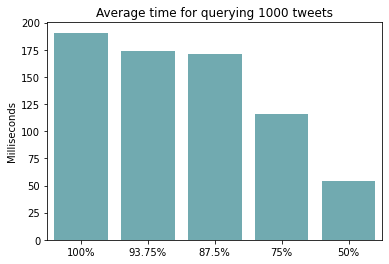

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))